In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from proteus.matrix import tseries as ts
from proteus.predic import prediction
from proteus.predic import predlib
from proteus.predic import betacluster as bc
from proteus.predic import clustering as hc
from proteus.visu import matrix as visu
#from proteus.predic import fselection as fselect
import pandas as pd
import scipy.io
from os import listdir
import cPickle as pickle

from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold,LeaveOneOut,GridSearchCV
from sklearn import preprocessing

import seaborn as sns
import nibabel as nib
from nilearn import plotting

In [3]:
scale_list=np.array([  7,  12,  20,  36,  64, 122, 197, 325, 444])

In [543]:
data = pd.read_csv('/media/cdansereau/database1/data/schizo/fmri_data/connectomes/model_R_conn_scale64.csv', index_col=0)

#im_ref_325 = nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale325.nii.gz')
#im_ref_7 = nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale007.nii.gz')
#im_ref = nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz')    


im_ref_all = nib.load('/media/cdansereau/database1/data/schizo/mstep_part_cambridge_05scrubb.nii.gz')
im_ref_7 = im_ref_all.get_data()[...,0]
im_ref_64 = im_ref_all.get_data()[...,4]


In [384]:


root_path = '/media/cdansereau/database1/data/schizo/fmri_data/corrmatrix_test/'
list_files = listdir(root_path)
print('Start loading ' + str(len(list_files)) + ' subjects...')
Zscales = []
Rscales = []
index = []
scale_list = []
for i in range(len(list_files)):
    tmp_mat = scipy.io.loadmat(root_path + list_files[i])
    print(tmp_mat['subj_id'][0])
    if tmp_mat['nframes'][0] > 40:
        Z = tmp_mat['Z'][0]
        R = tmp_mat['R'][0]
        index.append(tmp_mat['subj_id'][0])
        scale_list = tmp_mat['scale_list'][0].astype(int)
        if len(Zscales) == 0:
            for j in range(len(Z)):
                Zscales.append(Z[j].T)
                Rscales.append(R[j].T)
        else:
            for j in range(len(Z)):
                Rscales[j] = np.vstack((Rscales[j], R[j].T))



Start loading 84 subjects...
SZxxx0040004
HCxxx0040093
HCxxx0040116
HCxxx0040048
HCxxx0040036
HCxxx0040061
HCxxx0040114
SZxxx0040106
HCxxx0040014
SZxxx0040041
HCxxx0040134
SZxxx0040032
SZxxx0040000
SZxxx0040122
HCxxx0040104
SZxxx0040103
SZxxx0040028
SZxxx0040137
HCxxx0040013
SZxxx0040002
HCxxx0040062
SZxxx0040092
SZxxx0040112
HCxxx0040054
SZxxx0040109
SZxxx0040085
HCxxx0040055
HCxxx0040057
HCxxx0040121
SZxxx0040021
SZxxx0040029
SZxxx0040059
SZxxx0040072
HCxxx0040020
SZxxx0040132
HCxxx0040035
HCxxx0040147
SZxxx0040046
HCxxx0040067
SZxxx0040064
SZxxx0040117
SZxxx0040078
HCxxx0040050
HCxxx0040124
SZxxx0040037
SZxxx0040080
HCxxx0040146
SZxxx0040126
SZxxx0040077
HCxxx0040045
HCxxx0040019
SZxxx0040022
HCxxx0040066
HCxxx0040123
HCxxx0040027
SZxxx0040025
SZxxx0040108
HCxxx0040138
HCxxx0040115
SZxxx0040006
SZxxx0040099
SZxxx0040010
SZxxx0040133
SZxxx0040034
HCxxx0040131
HCxxx0040076
SZxxx0040081
HCxxx0040051
HCxxx0040120
SZxxx0040079
HCxxx0040129
HCxxx0040065
HCxxx0040023
SZxxx0040098
HCxxx0040

In [520]:
im_ref_all.get_data().shape

ind_7to64 = hc.get_ind_high2low(im_ref_all.get_data()[...,0].astype(int),im_ref_all.get_data()[...,4].astype(int))
sorted_idx = np.array(hc.order(ind_7to64))

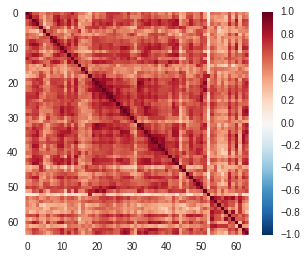

In [410]:

aa = vec2mat(data.loc['HCxxx0040013'].values, order='matlab')#[xx,:][:,xx]

#ind = hc.hclustering(aa,aa.shape[0])

visu.mat(aa,lim=[-1,1])
plt.grid(False)

In [522]:
reload(ts)

#ind_7to325 = hc.get_ind_high2low(im_ref_7.get_data(),im_ref_325.get_data())
#sorted_idx = np.array(hc.order(ind_7to325))

aa = ts.vec2mat(data.loc['HCxxx0040013'].values)#[sorted_idx,:][:,sorted_idx]

#ind = hc.hclustering(aa,aa.shape[0])

visu.mat(aa,lim=[-1,1])
plt.grid(False)

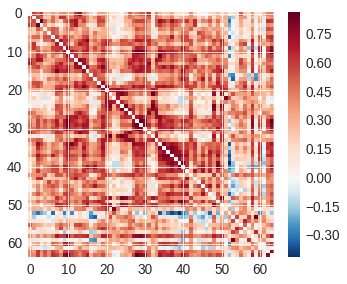

In [523]:

visu.mat(ts.vec2mat(data.iloc[0,:].values))


In [6]:
#demograph = pd.read_csv('/media/cdansereau/database1/data/schizo/model_schizo_4studies_psm_20160327.csv', index_col=0)
demograph = pd.read_csv('/media/cdansereau/database1/data/schizo/model_schizo_4studies_20160411.csv', index_col=0)

demograph = demograph.sort_index()
demograph.index = demograph.index.map(str.strip)
demograph.columns = demograph.columns.map(str.strip)

In [81]:
data.loc[demograph.index.values]

0         1         2         3         4         5  \
HCxxx0040013  0.822745  0.613569  0.618819  0.482358  0.467348  0.603452   
HCxxx0040014  0.551253  0.537035  0.552205  0.338470  0.069142  0.459512   
HCxxx0040018  0.866067  0.710845  0.743163  0.517877  0.645362  0.704039   
HCxxx0040019  0.719278  0.610556  0.649060  0.659975  0.476052  0.542125   
HCxxx0040020  0.677841  0.778305  0.772930  0.475143  0.337340  0.338208   
HCxxx0040023 -0.004898 -0.121280 -0.110315 -0.017681  0.170256  0.423114   
HCxxx0040027  0.580356  0.604724  0.687358  0.489521  0.295436  0.446978   
HCxxx0040035  0.699791  0.645311  0.613697  0.416755  0.378490  0.576792   
HCxxx0040036  0.849915  0.391166  0.516175  0.305435  0.397541  0.300283   
HCxxx0040043  0.640741  0.231725  0.480345  0.445184  0.357140  0.494031   
HCxxx0040045  0.670081  0.574104  0.470209  0.631709  0.681362  0.779909   
HCxxx0040048  0.826491  0.467965  0.639307  0.673726  0.520675  0.597925   
HCxxx0040050  0.847509  0.235858  0.275115  0.437119  0.380994  0.464721   
HCxxx0040051  0.928806  0.561208  0.619024  0.628858  0.107730  0.070885   
HCxxx0040054  0.354109  0.276145  0.119925  0.165802  0.481439  0.544716   
HCxxx0040055  0.714440  0.529259  0.243725  0.593740  0.476428  0.326063   
HCxxx0040057  0.657654  0.256836  0.284078  0.488937  0.416675  0.241525   
HCxxx0040061  0.817574  0.506410  0.846787  0.729603  0.488854  0.464768   
HCxxx0040062  0.846951  0.482983  0.521090  0.413228  0.603189  0.686362   
HCxxx0040065  0.882773  0.698737  0.631377  0.622684  0.657377  0.655772   
HCxxx0040066  0.530905  0.450772  0.732920  0.413708  0.366240  0.336009   
HCxxx0040067  0.866985  0.445337  0.631737  0.632035  0.469519  0.537842   
HCxxx0040076  0.671141  0.673834  0.770708  0.545378  0.252761  0.071403   
HCxxx0040091  0.741035  0.602682  0.759215  0.593502  0.544642  0.674288   
HCxxx0040093  0.640962  0.592448  0.375744  0.389249 -0.015808  0.132058   
HCxxx0040104  0.879293  0.780402  0.522435  0.549651  0.676433  0.494511   
HCxxx0040113  0.860701  0.756449  0.780728  0.542661  0.431872  0.720647   
HCxxx0040114  0.726861  0.805912  0.808656  0.537297  0.461133  0.845235   
HCxxx0040115  0.856079  0.395511  0.529707  0.632435  0.677233  0.640862   
HCxxx0040116  0.779649  0.653837  0.657982  0.555081  0.278545  0.605633   
...                ...       ...       ...       ...       ...       ...   
SZxxxSDSZ14   0.700814  0.516151  0.546091  0.568251  0.391120  0.360720   
SZxxxSDSZ15   0.530058  0.596951  0.761162  0.265079  0.051714 -0.022078   
SZxxxSDSZ21   0.600928  0.539124  0.677007  0.631141  0.198033  0.249338   
SZxxxSDSZ27   0.086210  0.217772  0.374556 -0.156042 -0.193619 -0.144967   
SZxxxSDSZ28   0.422454  0.182217  0.171754  0.245629  0.161285  0.589293   
SZxxxSDSZ32   0.496563  0.172313  0.587724  0.493613  0.367491  0.388320   
SZxxxSDSZ37   0.473175  0.600490  0.571383  0.530067  0.655931  0.549952   
SZxxxSDSZ38   0.353262  0.377857  0.594148  0.376967  0.240125  0.475515   
SZxxxSDSZ39   0.476346  0.638785  0.696573  0.301834  0.330009  0.308586   
SZxxxSDSZ46   0.475928  0.357279  0.478578  0.073249  0.274256  0.429231   
SZxxxSDSZ47   0.798981  0.504691  0.461986  0.608203  0.610446  0.665734   
SZxxxSDSZ48   0.702089  0.666954  0.831203  0.611019  0.175835  0.467621   
SZxxxSDSZ49  -0.093586  0.177548  0.439734  0.503271  0.132573  0.661540   
SZxxxSDSZ51   0.620372  0.579828  0.526278  0.745315  0.251621  0.454616   
SZxxxSDSZ52   0.779154  0.668140  0.714033  0.799818  0.389780  0.377628   
SZxxxSDSZ55   0.577783  0.466964  0.505665  0.590635  0.125098  0.106808   
SZxxxSDSZ60   0.679992  0.316307  0.360745  0.355432  0.439649  0.411909   
SZxxxSDSZ61   0.420285  0.302520  0.520345  0.414314  0.029726  0.419921   
SZxxxSDSZ62   0.675967  0.189103  0.451899  0.484434  0.204111  0.317428   
SZxxxSDSZ66   0.677421  0.235500  0.520921  0.658530  0.443317  0.499513   
SZxxxSDSZ67   0.837674  0.418548  0.554663  0.615086  0.435645  0.194

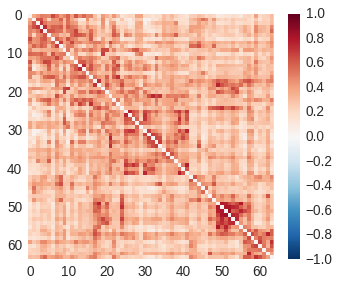

In [524]:
grand_avg = np.mean(data.loc[demograph.index.values].values,0)
visu.mat(ts.vec2mat(grand_avg)[sorted_idx,:][:,sorted_idx],lim=[-1,1])
plt.grid(False)

In [507]:

grand_avg = np.mean(data.loc[demograph.index.values].values,0)



aa = vec2mat(grand_avg, order='matlab')[sorted_idx,:][:,sorted_idx]
#ind = hc.hclustering(aa,aa.shape[0])
#sorted_idx = np.array(hc.order(ind))
#aa = aa[sorted_idx,:][:,sorted_idx]

visu.mat(aa,lim=[-1,1])
plt.grid(False)

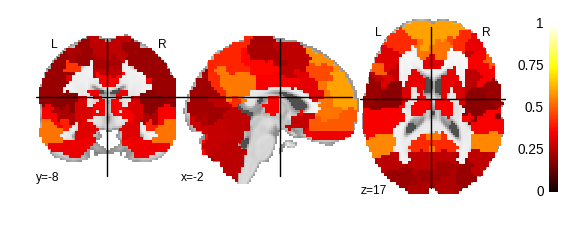

In [505]:
reload(ts)
zz = ts.vec2vol(aa[ind_7to64==1,:].mean(0), im_ref_all.get_data()[...,4])
#plt.imshow(aa[:,:,25])
plotting.plot_stat_map(nib.Nifti2Image(zz,im_ref_all.affine), colorbar=True,vmax=1,cut_coords=[-2,-8,17])

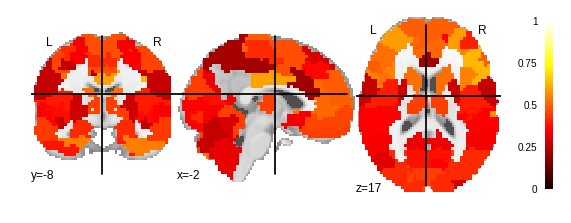

In [417]:
reload(ts)
zz = ts.vec2vol(ts.vec2mat(grand_avg)[18,:], im_ref.get_data())
#plt.imshow(aa[:,:,25])
plotting.plot_stat_map(nib.Nifti2Image(zz,im_ref.affine), colorbar=True,vmax=1,cut_coords=[-2,-8,17])

In [508]:
ind_sub = ind_7to64

In [335]:
def vec2mat(vec, order='python'):
    if order=='matlab':
        N = int(round((1 + math.sqrt(1 + 8 * len(vec))) / 2))

        a = np.ones((N,N))
        mask_ = np.triu(a, 1).astype(bool)
        a[mask_]=vec
        a.T[mask_]=vec
        
    return a
vec = np.array([2,3,4,5,8,9,10,14,15,20])
vec2mat(vec, order='matlab')

array([[  1.,   2.,   3.,   4.,   5.],
       [  2.,   1.,   8.,   9.,  10.],
       [  3.,   8.,   1.,  14.,  15.],
       [  4.,   9.,  14.,   1.,  20.],
       [  5.,  10.,  15.,  20.,   1.]])

In [297]:
import math
def vec2mat(vec, val_diag=0., include_diag=False, style='matlab'):
    
    if include_diag:
        N = int(round((-1 + math.sqrt(1 + 8 * len(vec))) / 2))
        mask_u = np.ones((N, N))
        mask_u = np.tril(mask_u, 0).astype(bool)
        b = np.ones((N, N))
    else:
        N = int(round((1 + math.sqrt(1 + 8 * len(vec))) / 2))
        mask_u = np.ones((N, N))
        mask_u = np.tril(mask_u, -1).astype(bool)
        b = np.ones((N, N)) * val_diag

    mask_nodiag = np.triu(np.ones((N, N)), 1).astype(bool)

    if style == 'matlab':
        # need to re index the values to the C order instead of F
        a = np.ones((N, N)).astype(int)
        a[np.tril(a, -1).astype(bool)] = np.arange(0, len(vec)).astype(int)
        new_vec = vec[a.T[mask_u]]
        b[mask_u] = new_vec
    else:
        b[mask_u] = vec

    # map to the lower triangle
    b.T[mask_nodiag] = b[mask_nodiag]
    return b
    
gg=vec2mat(np.arange(101,111),include_diag=False,style='matlab')
gg

array([[   0.,  101.,  102.,  104.,  107.],
       [ 101.,    0.,  103.,  105.,  108.],
       [ 102.,  103.,    0.,  106.,  109.],
       [ 104.,  105.,  106.,    0.,  110.],
       [ 107.,  108.,  109.,  110.,    0.]])

In [ ]:
import math
def vec2mat(vec, val_diag=0., include_diag=False, style='matlab'):
    
    if include_diag:
        N = int(round((-1 + math.sqrt(1 + 8 * len(vec))) / 2))
        mask_u = np.ones((N, N))
        mask_u = np.tril(mask_u, 0).astype(bool)
        b = np.ones((N, N))
    else:
        N = int(round((1 + math.sqrt(1 + 8 * len(vec))) / 2))
        mask_u = np.ones((N, N))
        mask_u = np.tril(mask_u, -1).astype(bool)
        b = np.ones((N, N)) * val_diag

    mask_nodiag = np.triu(np.ones((N, N)), 1).astype(bool)

    if style == 'matlab':
        # need to re index the values to the C order instead of F
        a = np.ones((N, N)).astype(int)
        a[np.tril(a, -1).astype(bool)] = np.arange(0, len(vec)).astype(int)
        new_vec = vec[a.T[mask_u]]
        b[mask_u] = new_vec
    else:
        b[mask_u] = vec

    # map to the lower triangle
    b.T[mask_nodiag] = b[mask_nodiag]
    return b
    
gg=vec2mat(np.arange(101,111),include_diag=False,style='matlab')
gg

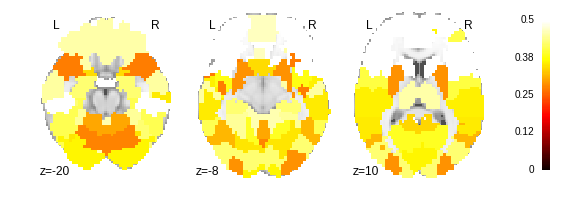

In [442]:
reload(ts)
aa = ts.vec2vol(vec2mat(grand_avg, order='matlab')[18,:], im_ref.get_data())
#plt.imshow(aa[:,:,25])
plotting.plot_stat_map(nib.Nifti1Image(aa,im_ref.affine),display_mode='z',cut_coords=[-20,-8,10], colorbar=True, vmax=0.5)

In [444]:
reload(ts)
aa = ts.vec2vol(vec2mat(grand_avg, order='matlab')[18,:], im_ref.get_data())
#plt.imshow(aa[:,:,25])
plotting.plot_epi(nib.Nifti1Image(aa,im_ref.affine), cut_coords=[0,-50,10],colorbar=True, vmin=0.25,vmax=0.75,cmap=plt.cm.jet)

In [98]:
ind_7to64[sorted_idx]

(242, 2016)

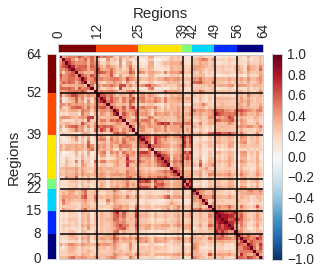

In [655]:
reload(visu)
import matplotlib as mpl

fig = plt.figure(figsize=(4, 4),dpi=150)
sns.set_context('paper',font_scale=1.7)

ind_sub = ind_7to64[sorted_idx].copy()
#visu.mat(hc.ordermat(grand_avg_sort,ind_sub),[-0.2,0.8],True,False)
visu.mat(ts.vec2mat(grand_avg,val_diag=1.)[sorted_idx,:][:,sorted_idx],[-1,1],True,False)

ax = plt.gca()
ax.grid(False)


def show_cluster(ind_sub,lw=1.5,color='w'):
    ax = plt.gca()
    # Use matplotlib directly to emphasize known networks
    networks = np.sort(ind_sub)
    for i, network in enumerate(networks):
        #print i, network
        if i and network != networks[i-1]:
            ax.axhline(i-0.5, c=color, lw=lw)
            ax.axvline(i-0.5, c=color, lw=lw)

show_cluster(ind_sub,color='k')


cmap = plt.cm.jet
ax_bar = fig.add_axes([0.085, 0.16, 0.03, 0.71])
ax_bar_top = fig.add_axes([0.124,0.877 , 0.71,0.03])
#bounds = np.linspace(0, 100, 7)
bounds=[0]
for i in range(7,0,-1):
        bounds.append(bounds[-1] + np.sum(ind_sub==i))

norm = mpl.colors.BoundaryNorm(bounds,cmap.N)


#mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap, norm=norm, spacing=np.sort(ind_sub), ticks=bounds ,boundaries=bounds,orientation='vertical')
cmm = mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap, norm=norm, spacing=bounds ,orientation='vertical')
#ax_bar.get_yaxis().set_ticks([])
#ax_bar.grid(False)
ax_bar.set_ylabel('Regions')
ax_bar.yaxis.tick_left()
ax_bar.yaxis.set_label_position('left')


cmap = plt.cm.jet_r
bounds=[0]
for i in range(1,8,1):
        bounds.append(bounds[-1] + np.sum(ind_sub==i))

norm = mpl.colors.BoundaryNorm(bounds,cmap.N)

cmm = mpl.colorbar.ColorbarBase(ax_bar_top, cmap=cmap, norm=norm, spacing=bounds ,orientation='horizontal')
#ax_bar_top.get_xaxis().set_ticks([])
#ax_bar_top.grid(False)
ax_bar_top.set_xlabel('Regions')
ax_bar_top.xaxis.tick_top()
ax_bar_top.xaxis.set_label_position('top')
ll = ax_bar_top.get_xticklabels()
for label in ll:
    label.set_rotation(90)

main_path = '/home/cdansereau/git/schizo_multisite/'
plt.savefig(main_path + 'figures/matrix_7net_multisite.pdf')
plt.savefig(main_path + 'figures/matrix_7net_multisite.png', dpi = 300, bbox_inches='tight')

In [604]:
(ind_sub==4).sum()

3

In [535]:
idx_cmap = np.linspace(0, 256, 64).astype(int)
cmaplist = [plt.cm.jet(idx_cmap[np.where(ind_sub==i)[0][0]]) for i in np.arange(1,8)]

In [536]:
ind_sub

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7])

In [657]:
# define the colormap
cmap = plt.cm.jet_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(256)]

# create the new map
#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds_sub = np.linspace(0, 64, 8)
bounds_sub = np.ceil(bounds_sub)

for i in range(1,len(bounds)):
    idx_t1 = int(np.round(256*(bounds_sub[i-1]/64.)))
    idx_t2 = int(np.round(256*(bounds_sub[i]/64.)))
    print cmap(idx_t1), idx_t1,idx_t2
    for j in range(idx_t1,idx_t2):
        
        if i==7:
            cmaplist[j]=cmap(idx_t2)
        elif i==6:
            cmaplist[j]=cmap(idx_t2)
        elif i==5:
            cmaplist[j]=cmap(idx_t2-15)
        elif i==4:
            cmaplist[j]=cmap(idx_t1+20)
        elif i==1:
            cmaplist[j]=cmap(idx_t1)
        else:
            cmaplist[j]=cmap(idx_t1)
            
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)   
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)



(0.5, 0.0, 0.0, 1.0) 0 40
(1.0, 0.24763979665940458, 0.0, 1.0) 40 76
(1.0, 0.77051561365286858, 0.0, 1.0) 76 112
(0.67994939911448449, 1.0, 0.28779253636938651, 1.0) 112 148
(0.2245414294750161, 1.0, 0.74320050600885501, 1.0) 148 184
(0.0, 0.61372549019607847, 1.0, 1.0) 184 220
(0.0, 0.049019607843137303, 1.0, 1.0) 220 256


In [659]:
nn_map = ts.vec2vol(ind_sub,im_ref.get_data())
im_over = nib.Nifti1Image(nn_map, im_ref.get_affine())


plotting.plot_roi(im_over,
                  cut_coords=(0, -4, 25), colorbar=True, cmap=cmap, draw_cross=False)

In [640]:

plotting.plot_roi(im_over,
                  cut_coords=(8, -4, 15), colorbar=True, cmap=plt.cm.jet)

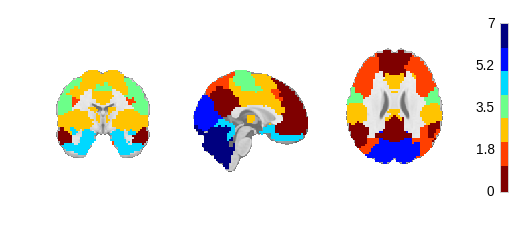

In [662]:
import nibabel as nib
from nilearn import plotting
#im_ref = nib.Nifti1Image(im_ref.get_data(), im_ref.get_affine())

anat_template = nib.load('/home/cdansereau/Dropbox/McGill-publication/papers/white_template.nii.gz')
    
fig = plt.figure(figsize=(15,10))

#data_dmn = 8-#all_sites[hc.order(ind_sub==2),:].mean(axis=0)

#vis.mat(hc.ordermat(rejected ,order),lim_mean_diff,False,False)

nn_map = ts.vec2vol(np.arange(1,8),im_ref_7)
im_over = nib.Nifti1Image(nn_map, im_ref_all.get_affine())
display = plotting.plot_anat(anat_img=anat_template,
                             #display_mode='z',
                             #cut_coords=[-25,-15,0,15,25,45],
                             cut_coords=(0, -5, 25),
                             annotate=False,
                             draw_cross=False,
                             )

display.add_overlay(im_over,
                    colorbar=True,
                    vmin=0,
                    vmax=7,
                    cmap=cmap)



plt.savefig('samples/networks_partition7.png', dpi = 300, bbox_inches='tight')

#im_over.to_filename('/home/cdansereau/git/Projects/multisite/partition_7networks.nii.gz')

In [546]:
import statsmodels.stats.multitest as smm
import statsmodels.api as sm

def test_diff(y, X):
    pval = []
    x_ = sm.add_constant(X)
    
    for nn in range(y.shape[1]):
        model = sm.OLS(y[:,nn], x_)
        res = model.fit()
        #print(res.summary())
        pval.append(res.pvalues[1])
    pval = np.array(pval)
    rejected , pvaluecorrected = smm.multipletests(pval, alpha=0.05, method='fdr_bh')[:2]
    rejected = ts.vec2mat(rejected,0)
    return rejected

In [ ]:
ind_7to64[sorted_idx]

In [664]:
import matplotlib.patches as patches
def plot_connectomes(demog_set,flag_diff_only=False, label=''):
    data_ = data.loc[demog_set.index.values].copy()
    if not flag_diff_only:
        plt.figure(figsize=(20,5))
    else:
        plt.figure()
    # HC
    if not flag_diff_only: 
        ax = plt.subplot(1,4,1)
        hc_vec = data_[(demog_set['sz']==0)].values.mean(0)
        hc_mat = hc.ordermat(ts.vec2mat(hc_vec), ind_7to64)
        visu.mat(hc_mat,[-1,1],True,False)
        plt.grid(False)
        show_cluster(ind_sub,color='k')
        p=patches.Rectangle(
            (-0.5, -0.5), 63.95, 63.95, fill=False,
            edgecolor=None,      # Default
            linewidth=3
        )
        ax.add_patch(p)
    
    # SZ
    if not flag_diff_only: 
        ax=plt.subplot(1,4,2)
        sz_vec = data_[(demog_set['sz']==1)].values.mean(0)
        sz_mat = hc.ordermat(ts.vec2mat(sz_vec), ind_7to64)
        visu.mat(sz_mat,[-1,1],True,False)
        plt.grid(False)
        show_cluster(ind_sub,color='k')
        p=patches.Rectangle(
                (-0.5, -0.5), 63.5, 63.5, fill=False,
                edgecolor=None,      # Default
                linewidth=3
            )
        ax.add_patch(p)
    # diff
    if not flag_diff_only: 
        ax=plt.subplot(1,4,3)
    else:
        ax = plt.subplot(111)
    diff = data_[(demog_set['sz']==1)].values.mean(0) - data_[(demog_set['sz']==0)].values.mean(0)
    diff_mat = hc.ordermat(ts.vec2mat(diff), ind_7to64)
    visu.mat(diff_mat,[-0.15,0.15],True,False)
    plt.grid(False)
    show_cluster(ind_sub,color='k')
    p=patches.Rectangle(
            (-0.5, -0.5), 63.5, 63.5, fill=False,
            edgecolor=None,      # Default
            linewidth=3
        )
    ax.add_patch(p)
    if flag_diff_only:
        plt.savefig('samples/univar_'+label+'.png', dpi = 300, bbox_inches='tight')
    # diff
    if not flag_diff_only: 
        ax = plt.subplot(1,4,4)
        rejected = test_diff(data_.loc[demog_set.index.values].values, demog_set[['sz']].values)
        diff_mat_reject = hc.ordermat(rejected, ind_7to64)
        #visu.mat(diff_mat*2.,lim=[0,1])
        
        print 'rejected',ts.mat2vec(diff_mat_reject).sum()
        visu.mat(diff_mat_reject,[0,1],True,False,plt.cm.Greys)
        plt.grid(False)
        show_cluster(ind_sub,color='k')
        p=patches.Rectangle(
                (-0.5, -0.5), 63.5, 63.5, fill=False,
                edgecolor=None,      # Default
                linewidth=3
            )
        ax.add_patch(p)

    plt.tight_layout()
    return ts.mat2vec(diff_mat)

rejected 800.0


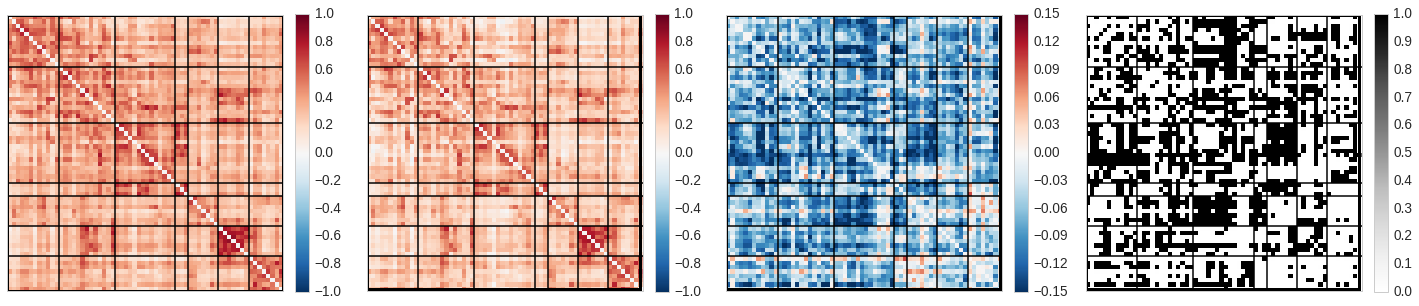

In [665]:
reload(ts)
# 1a over all the data
demog_set = demograph[(demograph['study']==1) | (demograph['study']==2)]
plot_connectomes(demog_set)
plt.savefig('samples/univar_main.png', dpi = 300, bbox_inches='tight')


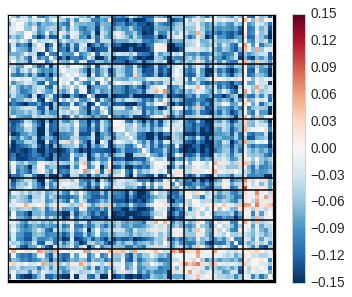

In [636]:
demog_set = demograph[(demograph['study']==1) | (demograph['study']==2)]
plot_connectomes(demog_set,flag_diff_only=True)
plt.savefig('samples/univar_main_diff.png', dpi = 300, bbox_inches='tight')

In [454]:
list_1site = np.array([[1,2,3,4]]).T

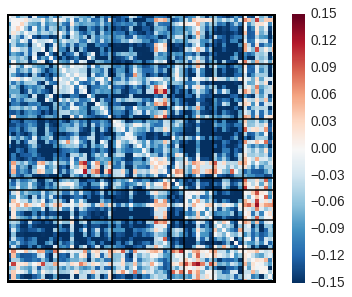

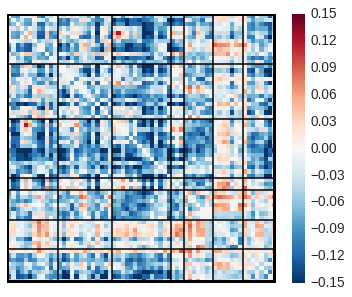

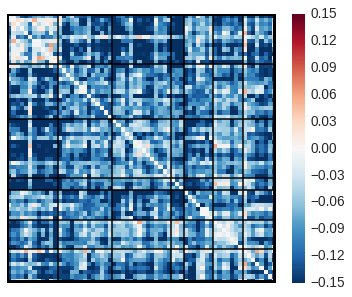

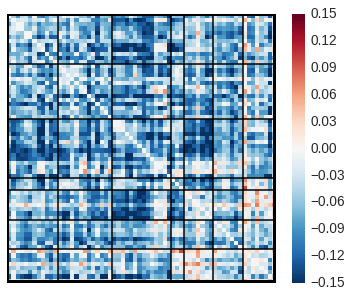

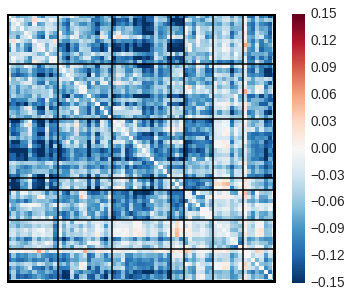

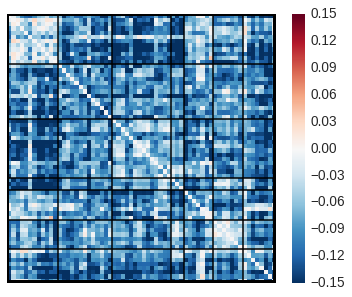

In [614]:
# 1b for each pair
main_correlation_comp = []
list_1site = np.array([[1,2,3,4]]).T
for ii in range(list_1site.shape[0]):
    demog_set = demograph[(demograph['study']==list_1site[ii,0])]
    label = ''.join(list_1site[ii,:].astype(str))
    main_correlation_comp.append(plot_connectomes(demog_set,flag_diff_only=True,label=label))

list_2site = np.array([[1,2],[1,3],[1,4],[2,3],[2,4],[3,4]])
for ii in range(list_2site.shape[0]):
    demog_set = demograph[(demograph['study']==list_2site[ii,0]) | (demograph['study']==list_2site[ii,1])]
    label = ''.join(list_2site[ii,:].astype(str))
    main_correlation_comp.append(plot_connectomes(demog_set,flag_diff_only=True,label=label))

list_3site = np.array([[1,2,3],[1,2,4],[1,3,4],[2,3,4]])
for ii in range(list_3site.shape[0]):
    demog_set = demograph[(demograph['study']==list_3site[ii,0]) | (demograph['study']==list_3site[ii,1]) | (demograph['study']==list_3site[ii,2])]
    label = ''.join(list_3site[ii,:].astype(str))
    main_correlation_comp.append(plot_connectomes(demog_set,flag_diff_only=True,label=label))

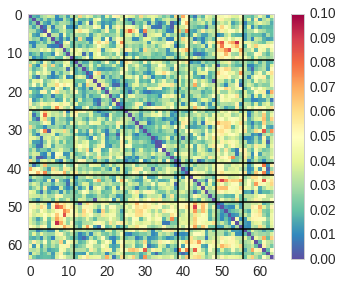

In [654]:

plt.imshow(ts.vec2mat(np.stack(main_correlation_comp).std(0),val_diag=0),interpolation='none', cmap=plt.cm.Spectral_r, vmax=0.1)
plt.colorbar()

plt.grid(False)
show_cluster(ind_sub,color='k')

plt.savefig('samples/univar_std.png', dpi = 300, bbox_inches='tight')


In [835]:
ts.mat2vec(np.corrcoef(np.stack(main_correlation_comp))).mean()
x

0.5906667815829858

In [615]:
# correlation between diff maps
fig = plt.figure()
ax=plt.subplot(1,1,1)
plt.imshow(np.corrcoef(np.stack(main_correlation_comp)),interpolation='none', cmap=plt.cm.Spectral_r,vmin=0,vmax=1)
plt.grid(False)
plt.colorbar()
p=patches.Rectangle(
        (-0.5, -0.5), 13.95, 13.95, fill=False,
        edgecolor=None,      # Default
        linewidth=3
    )
ax.add_patch(p)
plt.savefig('samples/univar_ari.png', dpi = 300, bbox_inches='tight')
                 
df = pd.DataFrame(np.corrcoef(np.stack(main_correlation_comp)))
df.to_csv('samples/univar_ari.csv')

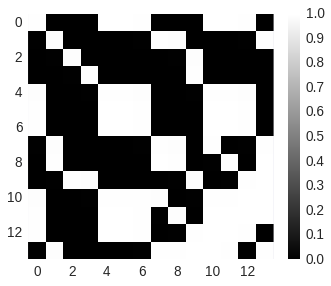

In [567]:
visu.mat(np.corrcoef(np.stack(main_correlation_comp))>0.7)
plt.grid(False)

# MULTIVARIATES

In [556]:
def train_model_4coef(select_data):
    y = select_data['sz'].values
    x = data.loc[select_data.index.values].values
    # train
    xtrain,ytrain = shuffle(x,y)
    clf = SVC(kernel='linear', class_weight='balanced', C=.1)
    clf, score = predlib.grid_search(clf, xtrain,ytrain, n_folds=3, verbose=False)
    clf.fit(xtrain,ytrain)
    coef = clf.coef_[0,:]
    return (coef-coef.mean())/coef.std()



In [569]:
ind_7to64

array([1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 5, 5, 2, 2, 6, 6, 6,
       6, 6, 2, 1, 3, 4, 3, 3, 1, 6, 2, 3, 3, 3, 2, 3, 3, 5, 1, 2, 2, 5, 5,
       3, 3, 5, 5, 2, 6, 7, 7, 7, 7, 7, 7, 3, 7, 3, 7, 4, 4])

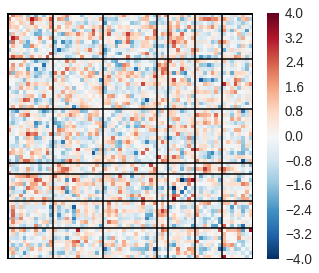

In [616]:
# 2a multivariate analysis all train on all sites

#plt.subplot(1,4,4)
plt.figure()
ax = plt.subplot(111)
coef = train_model_4coef(demograph)
coef_mat = hc.ordermat(ts.vec2mat(coef), ind_7to64)
#visu.mat(diff_mat*2.,lim=[0,1])
visu.mat(coef_mat,[-4,4],True,False,plt.cm.RdBu_r)
plt.grid(False)
show_cluster(ind_sub,color='k')
p=patches.Rectangle(
        (-0.5, -0.5), 63.95, 63.95, fill=False,
        edgecolor=None,      # Default
        linewidth=3
    )
ax.add_patch(p)
plt.savefig('samples/multivar_main_coefs.png', dpi = 300, bbox_inches='tight')

In [840]:
ind_sub

array([3, 5, 5, 5, 3, 2, 3, 3, 3, 5, 6, 6, 5, 3, 3, 2, 2, 2, 4, 4, 4, 4, 4,
       4, 4, 7, 7, 6, 6, 7, 3, 3, 4, 7, 6, 6, 6, 7, 7, 7, 3, 3, 5, 5, 2, 2,
       3, 7, 4, 2, 4, 4, 1, 4, 4, 1, 1, 1, 7, 4, 7, 1, 6, 6], dtype=int32)

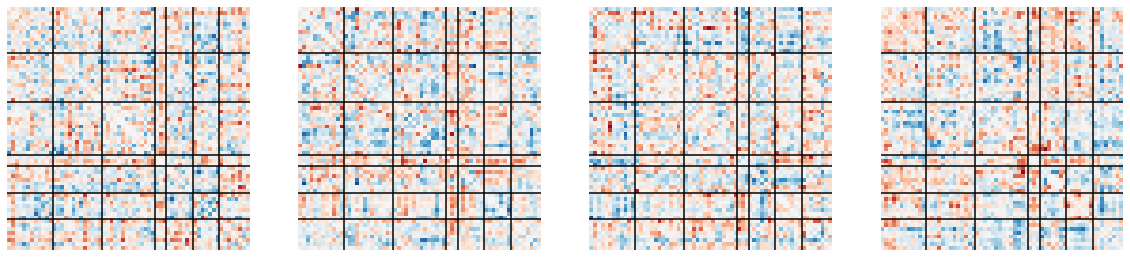

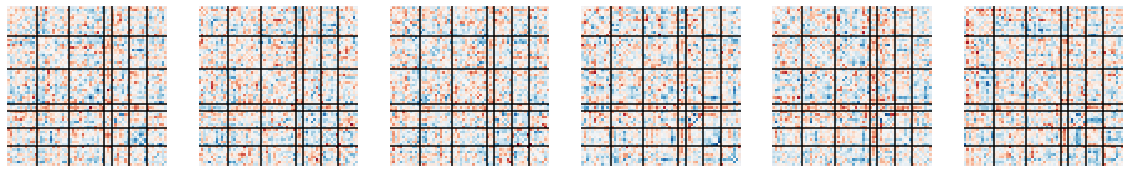

In [617]:
# 2b multivariate analysis train on 13 set of sites
main_correlation_comp_multivar = []
plt.figure(figsize=(20,5))
list_1site = np.array([[1,2,3,4]]).T
for ii in range(list_1site.shape[0]):
    plt.subplot(1,list_1site.shape[0],ii+1)
    coef = train_model_4coef(demograph[(demograph['study']==list_1site[ii,0])])
    main_correlation_comp_multivar.append(coef)
    coef_mat = hc.ordermat(ts.vec2mat(coef), ind_7to64)
    visu.mat(coef_mat,[-4,4],False,False,plt.cm.RdBu_r)
    plt.grid(False)
    show_cluster(ind_sub,color='k')

    
plt.figure(figsize=(20,5))
list_2site = np.array([[1,2],[1,3],[1,4],[2,3],[2,4],[3,4]])
for ii in range(list_2site.shape[0]):
    plt.subplot(1,list_2site.shape[0],ii+1)
    coef = train_model_4coef(demograph[(demograph['study']==list_2site[ii,0]) | (demograph['study']==list_2site[ii,1])])
    main_correlation_comp_multivar.append(coef)
    coef_mat = hc.ordermat(ts.vec2mat(coef), ind_7to64)
    visu.mat(coef_mat,[-4,4],False,False,plt.cm.RdBu_r)
    plt.grid(False)
    show_cluster(ind_sub,color='k')
    
    
plt.figure(figsize=(20,5))
list_3site = np.array([[1,2,3],[1,2,4],[1,3,4],[2,3,4]])
for ii in range(list_3site.shape[0]):
    plt.subplot(1,list_3site.shape[0],ii+1)
    coef = train_model_4coef(demograph[(demograph['study']==list_3site[ii,0]) | (demograph['study']==list_3site[ii,1]) | (demograph['study']==list_3site[ii,2])])
    main_correlation_comp_multivar.append(coef)
    coef_mat = hc.ordermat(ts.vec2mat(coef), ind_7to64)
    visu.mat(coef_mat,[-4,4],False,False,plt.cm.RdBu_r)
    plt.grid(False)
    show_cluster(ind_sub,color='k')

    

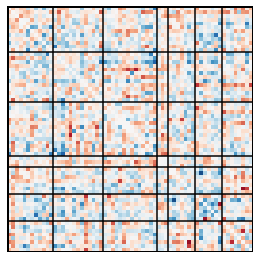

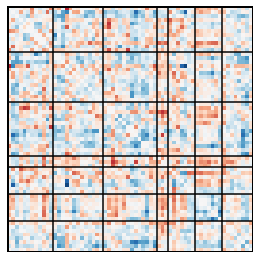

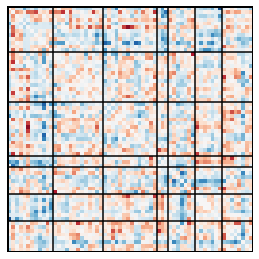

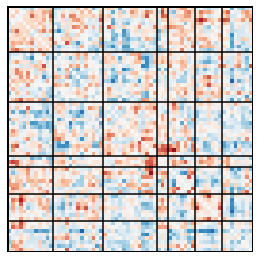

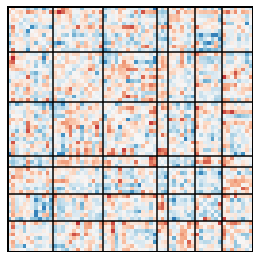

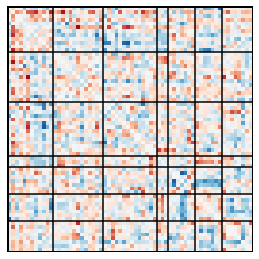

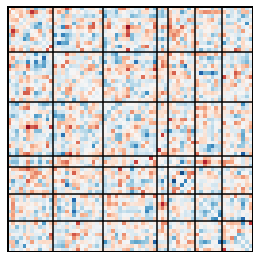

In [618]:
# 2b multivariate analysis train on 13 set of sites
main_correlation_comp_multivar = []


list_1site = np.array([[1,2,3,4]]).T
for ii in range(list_1site.shape[0]):
    plt.figure()
    ax=plt.subplot(111)
    coef = train_model_4coef(demograph[(demograph['study']==list_1site[ii,0])])
    main_correlation_comp_multivar.append(coef)
    coef_mat = hc.ordermat(ts.vec2mat(coef), ind_7to64)
    visu.mat(coef_mat,[-4,4],False,False,plt.cm.RdBu_r)
    plt.grid(False)
    show_cluster(ind_sub,color='k')
    p=patches.Rectangle(
        (-0.5, -0.5), 63.95, 63.95, fill=False,
        edgecolor=None,      # Default
        linewidth=3
    )
    ax.add_patch(p)
    plt.savefig('samples/multivar_'+''.join(list_1site[ii,:].astype(str))+'.png', dpi = 300, bbox_inches='tight')
    

list_2site = np.array([[1,2],[1,3],[1,4],[2,3],[2,4],[3,4]])
for ii in range(list_2site.shape[0]):
    plt.figure()
    ax=plt.subplot(111)
    coef = train_model_4coef(demograph[(demograph['study']==list_2site[ii,0]) | (demograph['study']==list_2site[ii,1])])
    main_correlation_comp_multivar.append(coef)
    coef_mat = hc.ordermat(ts.vec2mat(coef), ind_7to64)
    visu.mat(coef_mat,[-4,4],False,False,plt.cm.RdBu_r)
    plt.grid(False)
    show_cluster(ind_sub,color='k')
    p=patches.Rectangle(
        (-0.5, -0.5), 63.95, 63.95, fill=False,
        edgecolor=None,      # Default
        linewidth=3
    )
    ax.add_patch(p)
    plt.savefig('samples/multivar_'+''.join(list_2site[ii,:].astype(str))+'.png', dpi = 300, bbox_inches='tight')
    

list_3site = np.array([[1,2,3],[1,2,4],[1,3,4],[2,3,4]])
for ii in range(list_3site.shape[0]):
    plt.figure()
    ax=plt.subplot(111)
    coef = train_model_4coef(demograph[(demograph['study']==list_3site[ii,0]) | (demograph['study']==list_3site[ii,1]) | (demograph['study']==list_3site[ii,2])])
    main_correlation_comp_multivar.append(coef)
    coef_mat = hc.ordermat(ts.vec2mat(coef), ind_7to64)
    visu.mat(coef_mat,[-4,4],False,False,plt.cm.RdBu_r)
    plt.grid(False)
    show_cluster(ind_sub,color='k')
    p=patches.Rectangle(
        (-0.5, -0.5), 63.95, 63.95, fill=False,
        edgecolor=None,      # Default
        linewidth=3
    )
    ax.add_patch(p)
    plt.savefig('samples/multivar_'+''.join(list_3site[ii,:].astype(str))+'.png', dpi = 300, bbox_inches='tight')
    

In [651]:

plt.imshow(ts.vec2mat(np.stack(main_correlation_comp_multivar).std(0),val_diag=0),interpolation='none', cmap=plt.cm.Spectral_r)
plt.colorbar()

plt.grid(False)
show_cluster(ind_sub,color='k')

plt.savefig('samples/multivar_std.png', dpi = 300, bbox_inches='tight')
plt.savefig('samples/multivar_std.pdf', dpi = 300, bbox_inches='tight')

In [619]:
import matplotlib.patches as patches
# correlation matrix of all the coeff connectomes
fig = plt.figure(linewidth=2)
ax=plt.subplot(1,1,1)
plt.imshow(np.corrcoef(np.stack(main_correlation_comp_multivar)),interpolation='none',cmap=plt.cm.Spectral_r,vmin=0,vmax=1)
plt.grid(False)
plt.colorbar()
#ax = plt.Axes(fig, [0., 0., 1., 1.])
#ax.set_axis_off()
#fig.add_axes(ax)
p=patches.Rectangle(
        (-0.5, -0.5), 13.95, 13.95, fill=False,
        edgecolor=None,      # Default
        linewidth=3
    )
ax.add_patch(p)
plt.savefig('samples/multivar_ari.png', dpi = 300, bbox_inches='tight')

df = pd.DataFrame(np.corrcoef(np.stack(main_correlation_comp_multivar)))
df.to_csv('samples/multivar_ari.csv')

In [587]:
visu.mat(np.corrcoef(np.stack(main_correlation_comp_multivar))>0.7)
plt.grid(False)

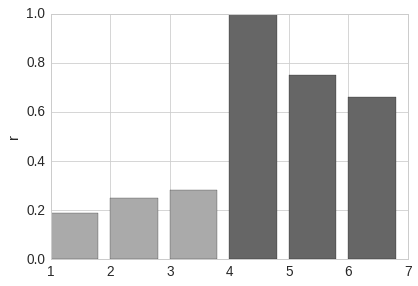

In [652]:
sns.set_style("whitegrid")
set_univar  = [0.19,0.25,0.28,1,0.75,0.66]
set_multivar= [0.08,0.11,0.12,1,0.65,0.53]
plt.figure()
colors = ['#aaaaaa', '#aaaaaa', '#aaaaaa', '#666666', '#666666' , '#666666']

plt.bar([1,2,3,4,5,6],set_univar,color=colors)
plt.ylabel('r')

plt.savefig('samples/cor_bar_univar.png', dpi = 300, bbox_inches='tight')

plt.figure()
plt.bar([1,2,3,4,5,6],set_multivar,color=colors)
plt.ylabel('r')

plt.savefig('samples/cor_bar_multivar.png', dpi = 300, bbox_inches='tight')